In [2]:
__author__ = "me"
__date__ = "2016_02_01"


import matplotlib
matplotlib.use('Agg')


%pylab inline


import matplotlib.pyplot as plt

import sqlite3
import datetime
import dateutil.parser

import pandas as pd

import geopandas as gp
from shapely.geometry import Point
from geopandas.tools import sjoin
import pysal

from palettable.cubehelix import red_16_r

import os
import ast

Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def getSQLiteTweets(path):
    '''gets all data as tuple'''
    conn = sqlite3.connect(path)
    data = conn.cursor().execute('SELECT * FROM tweets').fetchall() ## all but raw data
    conn.close()
    return data

def getDF(path):
    data = getSQLiteTweets(path)
    columns = ('id','timestamp','lon', 'lat', 'tweet', 'user_id', 'rtwts', 'fvrts', 'application', 'source')
    
    return pd.DataFrame(data, columns=columns )
    

In [4]:
def toGeoDataFrame(df, lat='Latitude',lon='Longitude'):
    '''dataframe to geodataframe'''
    df['geometry'] = df.apply(lambda z: Point(z[lon], z[lat]), axis=1)
    df = gp.GeoDataFrame(df)
    df.crs = {'init': 'epsg:4326', 'no_defs': True}
    return df 

In [113]:
def averageWeek(df, ax, tcol='ts', ccol='id', label=None, treshold=0, normalize=True, verbose=True, **kwargs):
    '''calculate average week on ts'''
    
    s = df[[tcol, ccol]].rename(columns={tcol:'ts',ccol:'id'}) # rename to convention
    
    s = df[['id', 'ts']].set_index('ts').resample('15Min', how='count').reset_index()
    s['id'] = s['id'].astype(float)


    s['ts'] = s.ts.apply(lambda x: datetime.datetime(year=2015,month=1, 
                                                              day=(x.weekday()+1), 
                                                              hour=x.hour, 
                                                              minute = x.minute))
    
    s = s.groupby(['ts']).agg('mean')
    
    
    if not label:
        label = ccol
    
    if s.id.sum() >= treshold:
        if normalize:
            sNorm = 1.0*s/s.sum()
        else:
            sNorm = s
        
        sNorm.rename(columns={'id':label}, inplace=1)
        
        sNorm.plot(ax=ax, legend=False, **kwargs);

        
        
    else:
        if verbose:
            print name, 'didnt pass treshhold:', s['id'].sum()
        else:
            pass
    
    return s.rename(columns={'id':label})

In [333]:
def bulkWeeks(df, attr, title='', av=False, th=0, legend=False, **kwargs):
    fig, ax = plt.subplots(figsize=(18,6))

    weeks = []


    for name, g in df.groupby(attr):
        
        zs = averageWeek(g, ax=ax, label=name, alpha=.5, treshold=th, **kwargs)
        weeks.append(zs)
    
    data = pd.concat(weeks, axis=1)
    if av:
        d = data.mean(axis=1)
        (1.0*d/d.sum()).plot(ax=ax, lw=1.4, color='k', label='Average')


    ax.set_title('%s, treshold=%d' % (title,treshold), fontsize=15);
    
    if legend:
        ax.legend()

    labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

    ax.set_xticklabels([],minor=False) # the default
    ax.set_xticklabels(labels,minor=True)

    for d in dates:
        ax.axvline(x=d, ymin=0, ymax=1)

    return data
    
    

## READING AND PROCESSING

In [126]:
path = '/Users/casy/Dropbox/CUSP/GRA/QQ_GRA/CUSP_QC_twitter_scripts/data/out_DB/2016-02-12 20:49:09_all.db'
df = getDF(path)

In [139]:
df['ts'] = pd.to_datetime(df.timestamp, unit='s')
df['ts'] = df['ts'] - datetime.timedelta(hours=5) ## UTS - 5h NYC

In [140]:
len(df)

743585

In [141]:
gdf  = toGeoDataFrame(df, lat='lon',lon='lat')  ### mesed with lat_long

In [142]:
gdf.columns

Index([u'id', u'timestamp', u'lon', u'lat', u'tweet', u'user_id', u'rtwts',
       u'fvrts', u'application', u'source', u'geometry', u'ts'],
      dtype='object')

In [357]:
gdf.timestamp.head(2)

0    1446689077
1    1446689152
Name: timestamp, dtype: int64

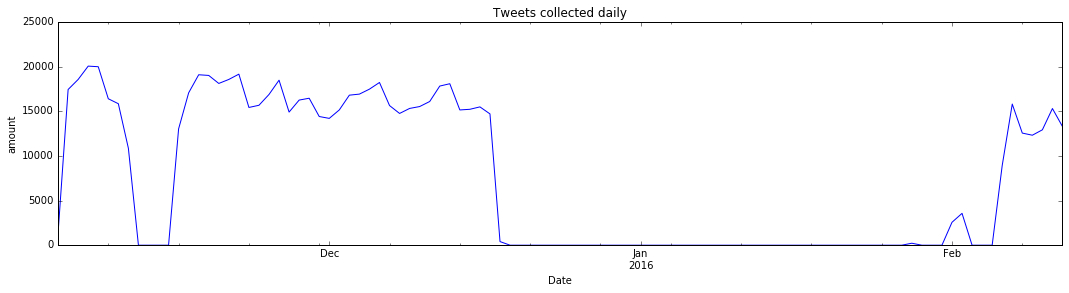

In [263]:
def timeCoverage(df, timeCol='ts', countCol='id', rs='D'):
    dft = df[[timeCol, countCol]].set_index(timeCol).resample(rs, how='count')
    dft.plot(figsize=(18,4), legend=0, title='Tweets collected daily');
    plt.xlabel('Date');
    plt.ylabel('amount');

timeCoverage(gdf)

## APPS

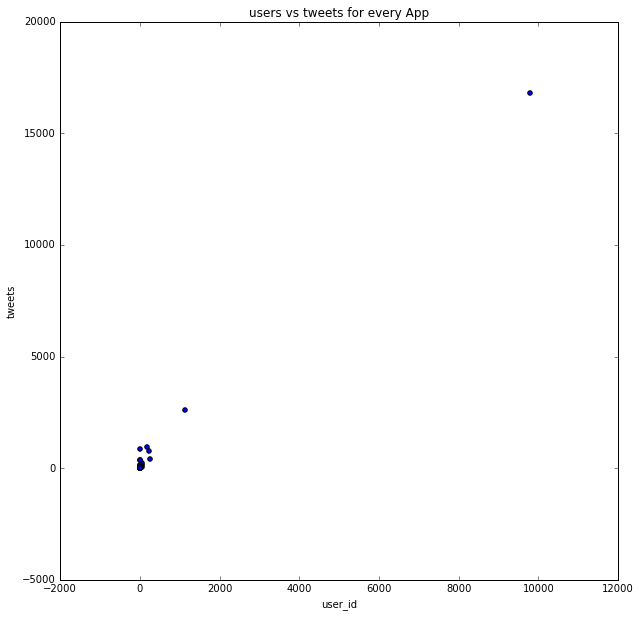

In [132]:
apps = gdf[['application','user_id', 'id']].groupby('application').agg({'user_id':pd.Series.nunique, 'id':'count'}).sort_values(by='user_id', ascending=0)
apps.rename(columns={'id':'tweets'}, inplace=1)
apps.plot(kind='scatter', x='user_id', y='tweets', logy=0, logx=0, figsize=(10,10), title='users vs tweets for every App');


In [131]:
len(gdf)

743585

In [143]:
len(gdf[(gdf.tweet.str.contains("I'm at")) | (gdf.application == 'Foursquare')])

46989

In [144]:
1.0 * len(gdf[(gdf.tweet.str.contains("I'm at")) | (gdf.application == 'Foursquare')])/len(gdf)

0.06319250657288676

In [145]:
len(gdf[pd.notnull(gdf.application)])

25304

In [146]:
apps.sort_values('tweets', ascending=0).head(10)

,user_id,tweets
application,,
Instagram,9778,16823
Foursquare,1135,2618
Twitter for Android,170,935
511NY-Tweets,11,848
Twitter for iPhone,236,784
Squarespace,256,398
TTN NYC traffic,1,358
dlvr.it,8,358
Tweetbot for iΟS,50,234


In [147]:
apps[apps.index.str.lower().str.contains('twitter')]
# apps.index

,user_id,tweets
application,,
Twitter for iPhone,236,784
Twitter for Android,170,935
Twitter for Android Tablets,29,148
Twitter for Windows Phone,28,115
twitterfeed,11,49
Twitter for iPad,10,59
Twitter for BlackBerry,6,8
Twitter for Android,2,2
Personal CLI Twitter Api,1,49


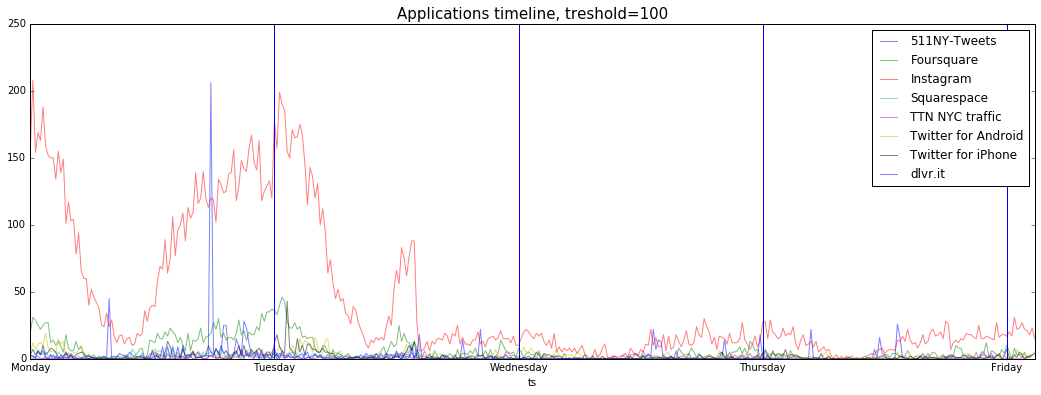

In [151]:
x = bulkWeeks(gdf, 'application', title='Applications timeline', av=False, th=250, legend=True, verbose=False, normalize=False)

In [323]:
def cdf(gdf, ax, **kwargs):
    users = gdf.user_id.value_counts( ascending=True ).cumsum()
    
    x = pd.qcut(users, 10)
    u = users.groupby(x).agg(sum)
    u = u.astype(float)/u.max()
    u.index = range(len(u))
    u.plot(**kwargs)

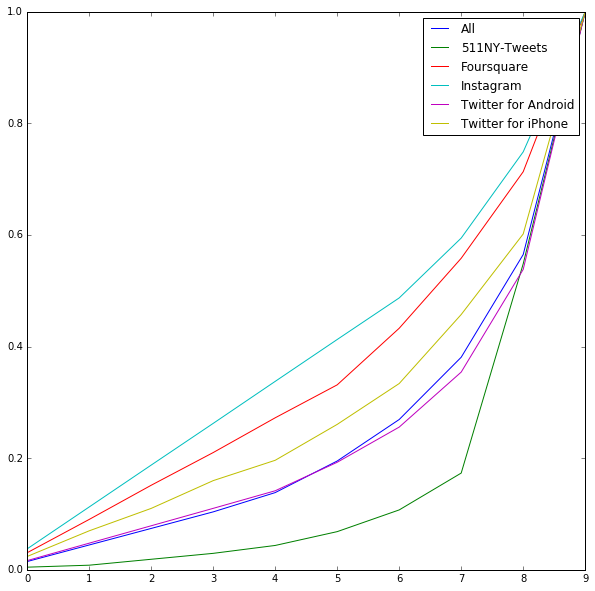

In [326]:
fig, ax = plt.subplots(figsize=(10,10))    

cdf(gdf, ax=ax, label='All')
th=500
for name, g in gdf.groupby('application'):
    if len(g) > th:
        cdf(g, ax=ax, label=name)
        
plt.legend();
plt.title('Apps user/impact ')

In [241]:
gdf[gdf.application == '511NY-Tweets'].user_id.value_counts()

50706690    383
52272942    318
50728535     56
50729679     33
55007804     21
55005906     12
55007056      9
55008355      9
55008759      4
55346033      2
55009968      1
Name: user_id, dtype: int64

In [188]:
gdf.source.value_counts()

twitter1.db                      626920
C_2016_02_12_twitter.db           33650
DO_2016_02_07_twitter.db          22016
DO_2016_02_12_twitter.db          15708
gnip                              13029
GNIP_Nov17_28                     12275
C_2016_02_9_twitterB.db           12095
C_2016_02_08.db                    3277
C_2016_02_7_Cusp_twitter.db        2701
C_2016_02_10.db                    1050
DO_2016_02__6_twitter.db            589
twitter2.db                         221
C_2016_92_7_Cusp_twitter_1.db        54
Name: source, dtype: int64

## ZIPS

In [152]:
zipPath = '/Users/casy/Dropbox/CUSP/GRA/QQ_GRA/CUSP_QC_twitter_scripts/data/misk/nyc-zip-code-tabulation-areas-polygons.geojson'
zips = gp.read_file(zipPath)[['geometry', 'postalCode']]

In [153]:
zips.head(2)

,geometry,postalCode
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004


In [154]:
zips.crs

{'init': u'epsg:4326'}

In [155]:
gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [156]:
gdf2 = sjoin(gdf, zips, how="left")


In [157]:
# gdf2.head(2)

In [158]:
gdf2.postalCode.value_counts().head(5)

10007    82563
10001    32950
10036    30088
10013    26079
10019    25574
Name: postalCode, dtype: int64

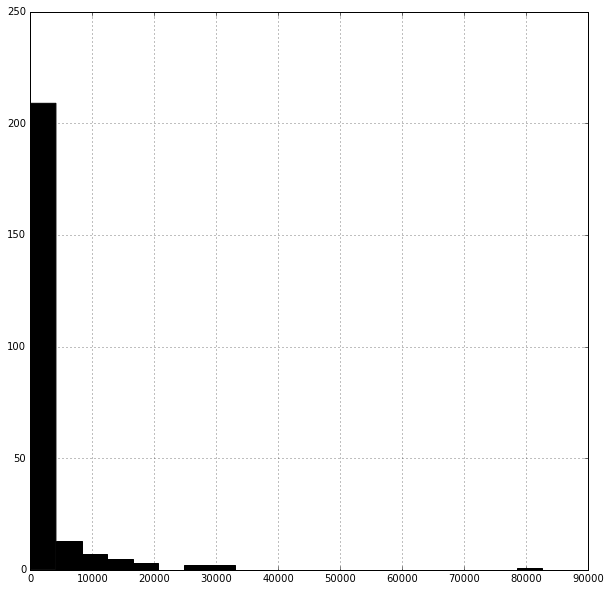

In [159]:
gdf2.postalCode.value_counts().hist(bins=20, figsize=(10,10), color='k');

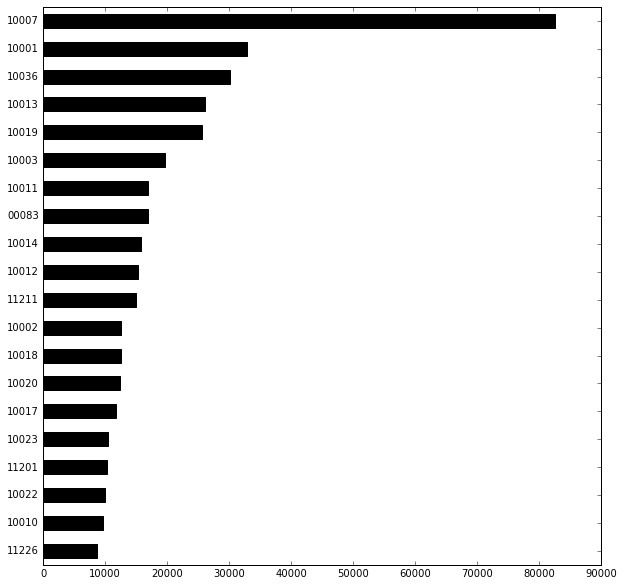

In [160]:
gdf2.postalCode.value_counts().sort_values(axis=0, ascending=False, inplace=0).head(20).iloc[::-1].plot(kind='barh', figsize=(10,10), color='k');
# plt.title('20 ZIPCODES with the most geolocated tweets')

## MAPPING ZIPS

In [161]:
zipheat = gdf2.postalCode.value_counts().reset_index().rename(columns={'index':'postalCode','postalCode':'tweetsTotal'})
zipheat.head(2)

,postalCode,tweetsTotal
0,10007,82563
1,10001,32950


In [162]:
zips2 = zips.merge(zipheat, on='postalCode', how='left')
zips2['normalized'] = zips2['tweetsTotal'] / zips2.geometry.area

In [163]:
zips2.head(2)

,geometry,postalCode,tweetsTotal,normalized
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1206,6030740.655333
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,42,187400.852643


In [164]:
zips2.tweetsTotal.sum()

691136.0

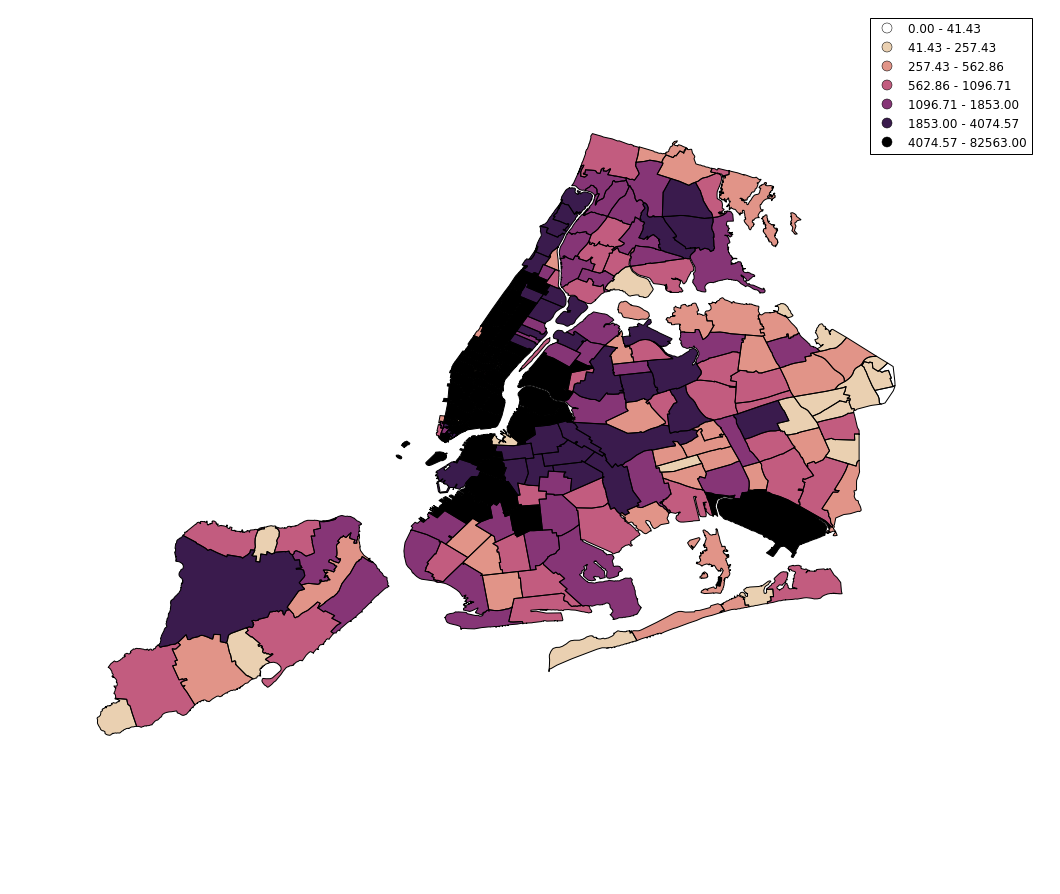

In [165]:
zips2[pd.notnull(zips2.tweetsTotal)].plot(column='tweetsTotal', scheme='QUANTILES', k=7, 
           colormap=red_16_r.mpl_colormap, figsize=(18,18),
           alpha=1, legend=True)

# plt.title('Total Number of tweets per zipcode', fontsize=20)
plt.axis('off');

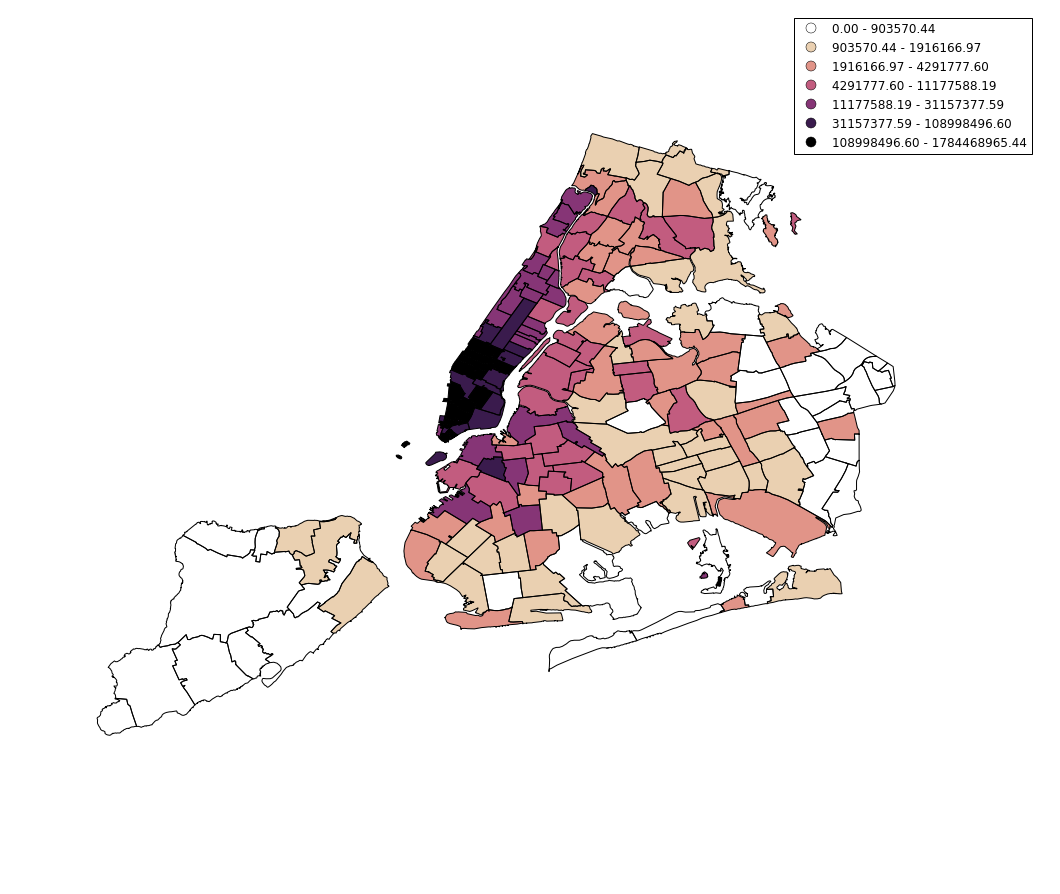

In [166]:
zips2[pd.notnull(zips2.tweetsTotal)].plot(column='normalized', scheme='QUANTILES', k=7, 
           colormap=red_16_r.mpl_colormap, figsize=(18,18),
           alpha=1, legend=True)

# plt.title('Number of tweets per zipcode, normalized by area', fontsize=20)
plt.axis('off');

## AVERAGE WEEK

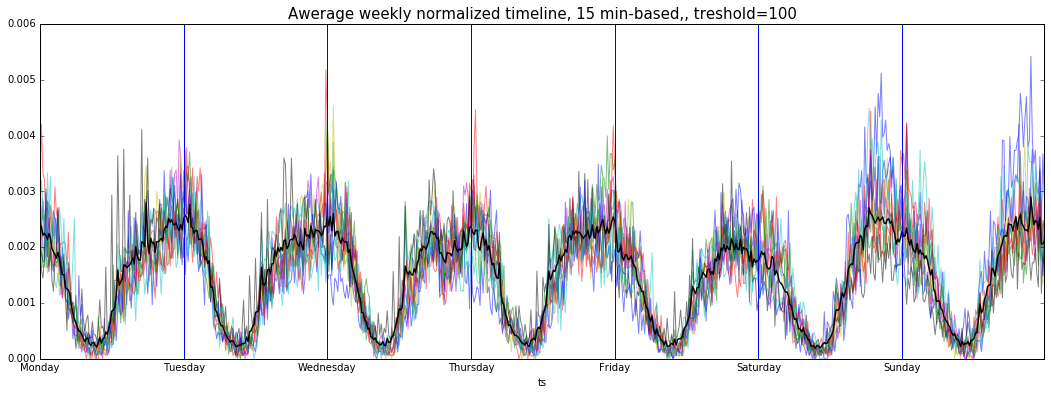

In [340]:
x = bulkWeeks(gdf2, 'postalCode', title='Awerage weekly normalized timeline, 15 min-based,',
          av=True, th=1000, legend=False, verbose=False)

## ROBOTS

In [175]:
gdf2[gdf2.application=='511NY-Tweets'].tweet.iloc[3]

u'Construction on #HollandTunnel EB from New Jersey Side - South Tube to New York Side - South Tube https://t.co/zIbmXjfekb'

In [244]:
def cleanRobots(df):
    '''first attempt to remove robots'''
    apps = ['511NY-Tweets']
    users = []
    
    # add app_robot_users --- for our scraper data, that lacks app_signature
    users.extend(df[df.application.isin(apps)].user_id.unique().tolist())
    print users
    return df[(~ df.application.isin(apps)) & (~ df.user_id.isin(users))]
    

In [245]:
def removeSingles(df):
    users = df.user_id.value_counts()
    singles = users[users==1].index.tolist()
    
    return df[ ~ df.user_id.isin(singles)]


In [251]:
# clean = removeSingles(cleanRobots(gdf2))
clean = cleanRobots(gdf2)

[52272942, 50706690, 55008759, 55007056, 55008355, 55005906, 55007804, 55346033, 55009968, 50728535, 50729679]


In [252]:
len(clean)

727120

In [253]:
users = clean
top = users.head(30).index.tolist()

In [254]:

cleanData = clean

In [255]:
len(cleanData)

727120

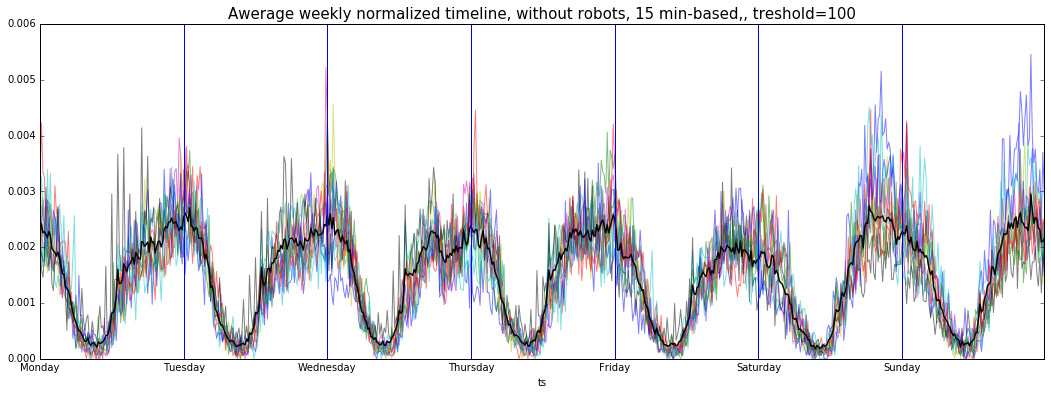

In [257]:
x = bulkWeeks(cleanData, 'postalCode', title='Awerage weekly normalized timeline, without robots, 15 min-based,',
          av=True, th=1000, legend=False, verbose=False)

In [258]:
LM = [str(x) for x in [10004, 10005, 10006, 10007, 10038, 10280]]

In [259]:
LMdata = cleanData[cleanData.postalCode.isin(LM)]

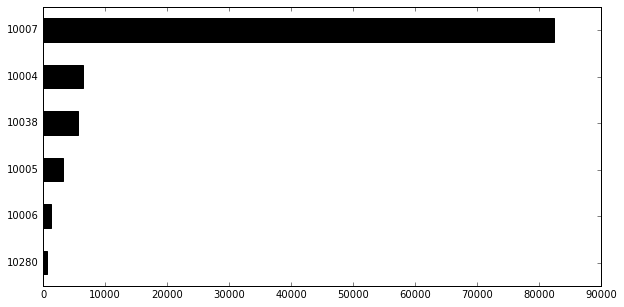

In [260]:
LMdata.postalCode.value_counts().iloc[::-1].plot(kind='barh', color='k', figsize=(10,5))

In [261]:
LMdata.head()

,id,timestamp,lon,lat,tweet,user_id,rtwts,fvrts,application,source,geometry,ts,index_right,postalCode
224,662038522858106881,1446695258,40.714200,-74.006400,🌆 | #nyc #officeview #instagramnyc #vscocam @...,129861900,NaN,NaN,None,twitter1.db,POINT (-74.0064 40.7142),2015-11-04 22:47:38,129,10007
237,662038714256769024,1446695304,40.714353,-74.005973,"#NewYork, NY #BusinessMgmt #Job: Accenture Str...",24220809,NaN,NaN,None,twitter1.db,POINT (-74.00597310000001 40.7143528),2015-11-04 22:48:24,129,10007
239,662038789066502144,1446695322,40.714200,-74.006400,Halibut Ceviche with Mango. Check it out on pa...,242079218,NaN,NaN,None,twitter1.db,POINT (-74.0064 40.7142),2015-11-04 22:48:42,129,10007
248,662038960177152008,1446695362,40.714353,-74.005973,"If you're a #IT professional in #NewYork, NY, ...",99353722,NaN,NaN,None,twitter1.db,POINT (-74.00597310000001 40.7143528),2015-11-04 22:49:22,129,10007
253,662038996457910272,1446695371,40.714353,-74.005973,Can you recommend anyone for this #Sales #job?...,20832061,NaN,NaN,None,twitter1.db,POINT (-74.00597310000001 40.7143528),2015-11-04 22:49:31,129,10007


In [327]:
len(gdf)

743585

In [328]:
len(LMdata)

99501

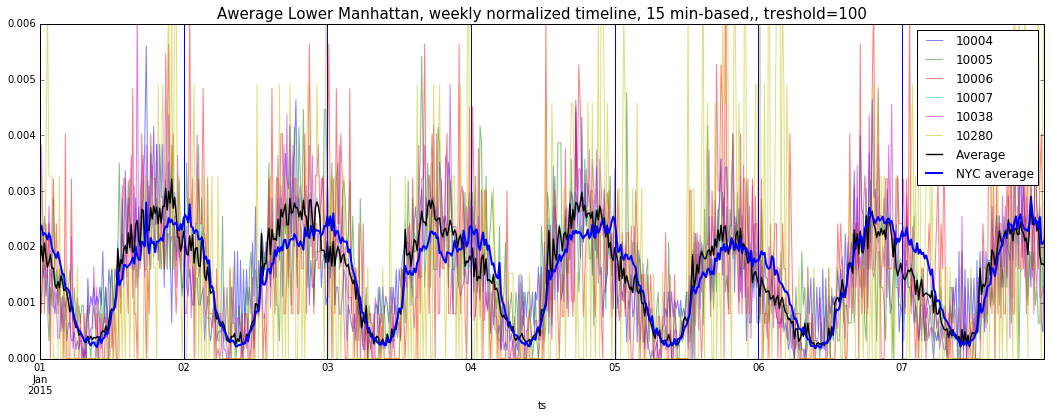

In [356]:
lmweek = bulkWeeks(LMdata, 'postalCode', title='Awerage Lower Manhattan, weekly normalized timeline, 15 min-based,',
          av=True, th=0, legend=True, verbose=False)

aW = x.mean(1)
aW = aW/aW.sum()
aW.plot(lw=2, c='blue', label='NYC average')
plt.ylim(0,0.006)
plt.legend()